# Physical k-folds validation.

It is written "physical" because the different folds are already created here => https://github.com/albertovpd/viu_tfm-deep_vision_classification/blob/kfolds_validation/src/creating_5_subfolders_for_kfoldslike_validation.ipynb

Assuming that train-val datasets are for training models and test dataset for fine-tuning:
- always the same test dataset: 150 pics randomly chosen of each class
- with the rest of pics:
  - regular folders: working with 5 folders, each one shuffled, dividing pics 80% for train dataset and 20% for val dataset. To check the goodness of shuffled data.
  - irregular folders: each one shuffled, 20% always for the val dataset. From the remaining 80%, taking the  80%, 62%, 46%, 30%, 20%, 10% of it for the train dataset. To check performance vs lack of data.


In [ ]:
# Google Drive stuff
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Mar  3 09:26:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# tf
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- libs

In [ ]:
%tensorflow_version 2.x
# batch ingestion of pics without pickle
from tensorflow.keras.preprocessing import image_dataset_from_directory

# nns
from tensorflow.keras.applications import ResNet50 

from tensorflow.keras import Model
from tensorflow.keras.models import load_model # Sequential
from tensorflow.keras import layers 

# optimization
from tensorflow.keras.optimizers import SGD #Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

# nn architectures, metrics, viz & reports => written in my_functions202202 file
import sys
sys.path.append("/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/src")
from my_functions202202 import generic_last_2layers, plotting_model, model_evaluation, classification_report_pic, confusion_matrix_report

import numpy as np
%matplotlib inline

# navigating through folder
import os

- paths

In [ ]:
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"
test_folder = base_folder+"input/dataset_1test_5trainval_folders/test_ds/"
print(test_folder)
# regular folders for train set
reg_input = base_folder+"input/dataset_1test_5trainval_folders/train_val_ds/trainval_regular_partitions/"
irreg_input = base_folder+"input/dataset_1test_5trainval_folders/train_val_ds/trainval_irregular_partitions/"
src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1test_5trainval_folders/test_ds/


- functions

In [ ]:
#my_functions202202.py

- common parameters

In [ ]:
image_size = (128,128)
batch_size = 128
epochs = 250
opt = SGD(momentum=0.9) 

In [ ]:
base_model_resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5) 
models_dict = {"resnet50_NOdataAug_dropoutFirst007": 
         generic_last_2layers(data_augmentation= None, nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.07)
         }

In [ ]:
test_ds = image_dataset_from_directory(
    test_folder,
      class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
      seed=None,
      validation_split=None, 
      subset=None,
      image_size= image_size,
      batch_size= batch_size,
      color_mode='rgb',
      shuffle=False 
  )

Found 750 files belonging to 5 classes.


# Regular partitions for traint set

In [ ]:
total = 0
for root, dirs, files in os.walk(reg_input):
    total += len(files)
    print(dirs, len(files))

['fold1', 'fold2', 'fold4', 'fold0', 'fold3'] 0
['train_ds', 'val_ds'] 0
['Dinning', 'Bedroom', 'Livingroom', 'Kitchen', 'Bathroom'] 0
[] 806
[] 878
[] 898
[] 652
[] 364
['Dinning', 'Bedroom', 'Livingroom', 'Kitchen', 'Bathroom'] 0
[] 202
[] 220
[] 225
[] 163
[] 92
['train_ds', 'val_ds'] 0
['Dinning', 'Bedroom', 'Livingroom', 'Kitchen', 'Bathroom'] 0
[] 806
[] 878
[] 898
[] 652
[] 364
['Bedroom', 'Bathroom', 'Livingroom', 'Kitchen', 'Dinning'] 0
[] 220
[] 92
[] 225
[] 163
[] 202
['train_ds', 'val_ds'] 0
['Dinning', 'Bedroom', 'Livingroom', 'Kitchen', 'Bathroom'] 0
[] 806
[] 878
[] 898
[] 652
[] 364
['Dinning', 'Bedroom', 'Livingroom', 'Kitchen', 'Bathroom'] 0
[] 202
[] 229
[] 225
[] 163
[] 92
['train_ds', 'val_ds'] 0
['Livingroom', 'Kitchen', 'Dinning', 'Bedroom', 'Bathroom'] 0
[] 898
[] 652
[] 806
[] 878
[] 364
['Dinning', 'Bathroom', 'Bedroom', 'Livingroom', 'Kitchen'] 0
[] 202
[] 92
[] 220
[] 225
[] 163
['train_ds', 'val_ds'] 0
['Kitchen', 'Livingroom', 'Bathroom', 'Dinning', 'Bedro

In [ ]:
os.listdir(reg_input)

['fold1', 'fold2', 'fold4', 'fold0', 'fold3']

In [ ]:
remaining_folders = os.listdir(reg_input)[4:]
remaining_folders

['fold3']


 FOLDER :  fold3
train dataset
Found 3598 files belonging to 5 classes.

 val dataset
Found 902 files belonging to 5 classes.
['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']

 resnet50_NOdataAug_dropoutFirst007
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Train

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


29/29 [==============================] - 153s 5s/step - loss: 89.6659 - accuracy: 0.3513 - val_loss: 323.4774 - val_accuracy: 0.2494
Epoch 2/250
29/29 [==============================] - 8s 276ms/step - loss: 434.6594 - accuracy: 0.0231 - val_loss: 200.5854 - val_accuracy: 0.2084
Epoch 3/250
29/29 [==============================] - 8s 281ms/step - loss: 218.6346 - accuracy: 0.1120 - val_loss: 127.0345 - val_accuracy: 0.3647
Epoch 4/250
29/29 [==============================] - 8s 282ms/step - loss: 309.7592 - accuracy: 0.0820 - val_loss: 103.4285 - val_accuracy: 0.4091
Epoch 5/250
29/29 [==============================] - 8s 280ms/step - loss: 192.1047 - accuracy: 0.1882 - val_loss: 81.4614 - val_accuracy: 0.4346
Epoch 6/250
29/29 [==============================] - 8s 280ms/step - loss: 234.6905 - accuracy: 0.1156 - val_loss: 86.3833 - val_accuracy: 0.4523
Epoch 7/250
29/29 [==============================] - 8s 276ms/step - loss: 220.5865 - accuracy: 0.1615 - val_loss: 74.4574 - val_accur

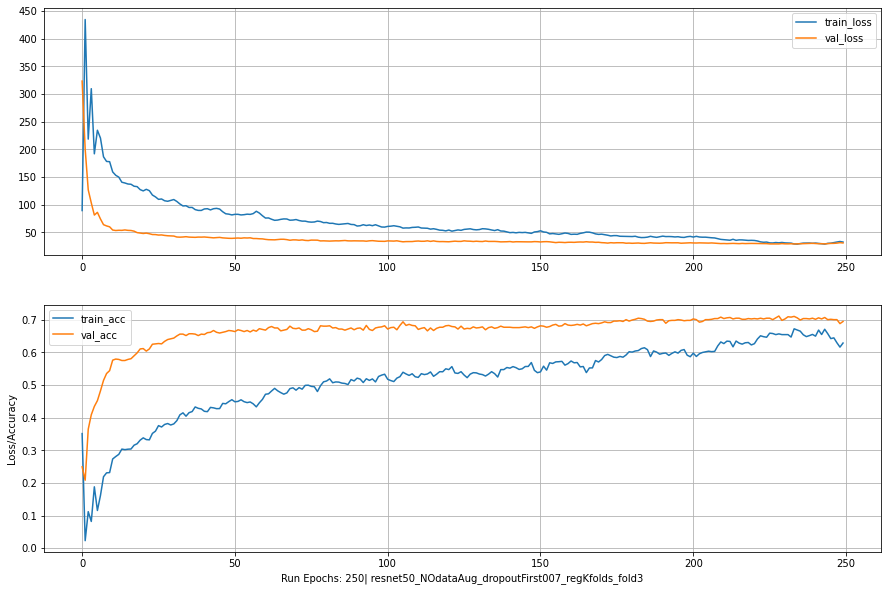

8/8 [==============================] - 2s 206ms/step - loss: 31.0693 - accuracy: 0.6951
              precision    recall  f1-score   support

     Bedroom       0.69      0.83      0.75       182
    Bathroom       0.66      0.91      0.77        67
     Dinning       0.58      0.75      0.65       156
  Livingroom       0.75      0.63      0.68       266
     Kitchen       0.80      0.56      0.66       231

    accuracy                           0.70       902
   macro avg       0.69      0.74      0.70       902
weighted avg       0.71      0.70      0.69       902



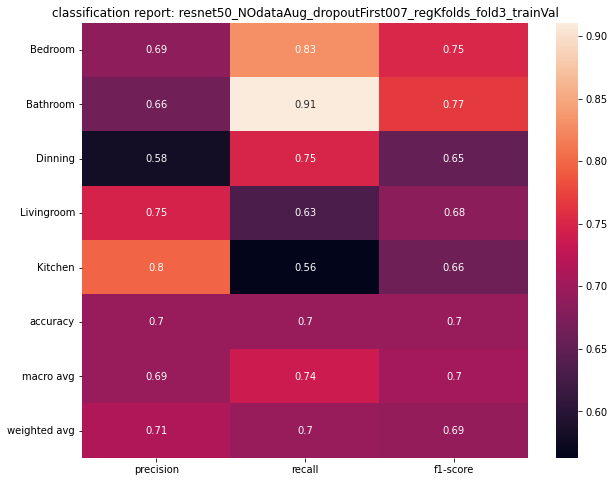

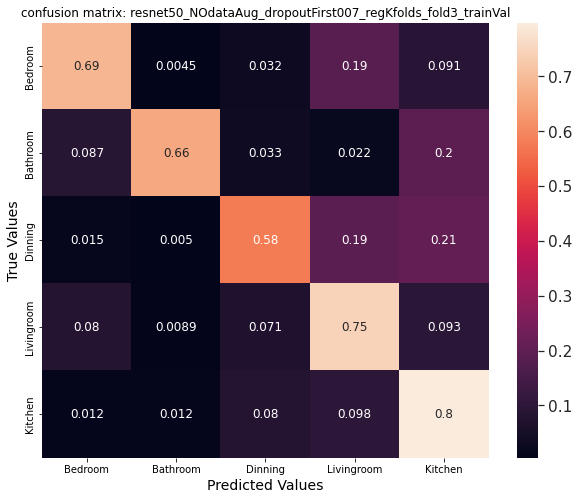

6/6 [==============================] - 2s 315ms/step - loss: 27.0902 - accuracy: 0.6880
              precision    recall  f1-score   support

     Bedroom       0.81      0.87      0.84       140
    Bathroom       0.54      0.89      0.67        91
     Dinning       0.53      0.71      0.61       113
  Livingroom       0.73      0.59      0.65       185
     Kitchen       0.83      0.56      0.67       221

    accuracy                           0.69       750
   macro avg       0.69      0.72      0.69       750
weighted avg       0.72      0.69      0.69       750



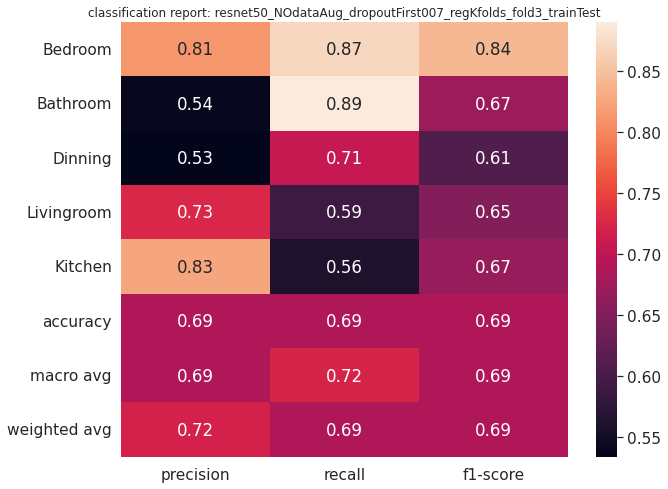

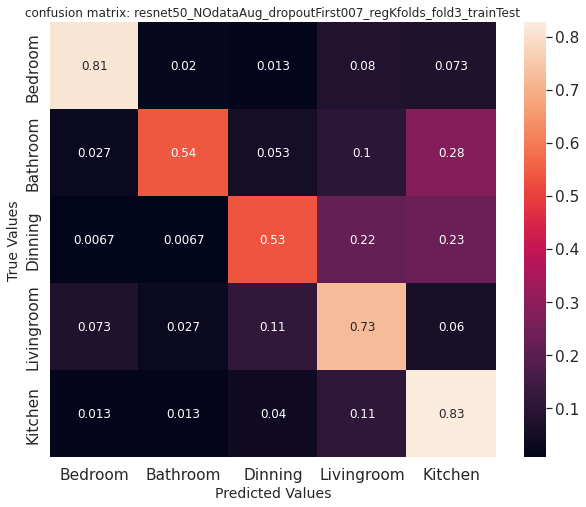

In [ ]:
for f in remaining_folders:
    print("\n ================================",
          "\n FOLDER : ",f)
    print("train dataset")
    train_path = reg_input+f+"/"+'train_ds/'
    train_ds = image_dataset_from_directory(
        train_path,
        class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
        seed=None,
        validation_split=None, 
        subset=None,
        image_size= image_size,
        batch_size= batch_size,
        color_mode='rgb',
        shuffle=False 
        )

    print("\n val dataset")
    val_path = reg_input+f+"/"+"val_ds"
    val_ds = image_dataset_from_directory(
      val_path,
      class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
      seed=None,
      validation_split=None, 
      subset=None,
      image_size= image_size,
      batch_size= batch_size,
      color_mode='rgb',
      shuffle=False 
    )

    class_names = train_ds.class_names
    print(class_names)

    # calling model
    model_name, nn = list(models_dict.items())[0]
    print("\n", model_name)
    nn.summary()

    nn.compile( optimizer = opt, #"adam", 
                  loss=SparseCategoricalCrossentropy(from_logits=True) ,#'categorical_crossentropy', 
                  metrics=['accuracy'] # "recall"
                  )

    # # ====== USING VAL DATASET ======

    history = nn.fit(
          train_ds,
          validation_data=val_ds,
          epochs=epochs,
          #callbacks = callbacks # <=== REMOVE CALLBACK for full results
          )

    number_of_epochs_it_ran = len(history.history['loss']) 
    print("run epochs: ",number_of_epochs_it_ran)
    name = model_name+"_regKfolds_"+f
    # save model => https://www.tensorflow.org/tutorials/keras/save_and_load
    nn.save(output_folder+name+".h5")

    # saving model accuracy/loss graph
    plotting_model(history,number_of_epochs_it_ran, name, output_folder, "val") 

    # saving model metrics to json
    evaluation = nn.evaluate(val_ds, batch_size=batch_size, return_dict=True)
    model_evaluation(evaluation, output_folder, name+"_trainVal")

    # get inferences
    y_pred_float_val = nn.predict(val_ds)
    y_pred_val = np.argmax(y_pred_float_val, axis=1)

    # get real labels
    y_target_val = tf.concat([y for x, y in val_ds], axis=0) 

    # classification and confusion matrix reports
    classification_report_pic(y_pred_val, y_target_val, class_names, output_folder, name+"_trainVal")
    confusion_matrix_report(  y_pred_val, y_target_val, class_names, output_folder, name+"_trainVal")
    #del y_pred_val, y_target_val

    # ====== USING TEST DATASET ======

    # saving model metrics to json
    evaluation_test = nn.evaluate(test_ds, batch_size=batch_size, return_dict=True)
    model_evaluation(evaluation_test, output_folder, name+"_trainTest")

    # get inferences
    y_pred_float_test = nn.predict(test_ds)
    y_pred_test = np.argmax(y_pred_float_test, axis=1)

    # get real labels for test_ds
    y_target_test = tf.concat([y for x, y in test_ds], axis=0) 

    # classification and confusion matrix reports
    classification_report_pic(y_pred_test, y_target_test, class_names, output_folder, name+"_trainTest")
    confusion_matrix_report(  y_pred_test, y_target_test, class_names, output_folder, name+"_trainTest")

In [ ]:
asdfasdfasdfasdfasdf

# Irregular partitions for train set

The motivation is to check performance vs lack of data. Then:

- 150 pics for each class are saved in the val_ds (indeed, the very same than before)
- with the rest of them, 4 subfolders are created. each time the data is randomly shuffled:
  - 20% are stored in test_ds folder
  - 80%, 62%, 46%, 30% of the remaining pics are saved for the train dataset. The rest is discarded.



In [ ]:
os.listdir(irreg_input)

In [ ]:
total = 0
for root, dirs, files in os.walk(irreg_input):
    total += len(files)
    print(dirs, len(files))

In [ ]:
remaining_folders_irr = os.listdir(irreg_input)[2:3]
remaining_folders_irr

In [ ]:
for f in remaining_folders_irr:
    print("\n ================================",
          "\n FOLDER : ",f)
    print("train dataset")
    train_path = irreg_input+f+"/"+'train_ds/'
    train_ds = image_dataset_from_directory(
        train_path,
        class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
        seed=None,
        validation_split=None, 
        subset=None,
        image_size= image_size,
        batch_size= batch_size,
        color_mode='rgb',
        shuffle=False 
        )

    print("\n val dataset")
    val_path = irreg_input+f+"/"+"val_ds"
    val_ds = image_dataset_from_directory(
      val_path,
      class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
      seed=None,
      validation_split=None, 
      subset=None,
      image_size= image_size,
      batch_size= batch_size,
      color_mode='rgb',
      shuffle=False 
    )

    class_names = train_ds.class_names
    print(class_names)

    # checking numbers non sense now because all have same volume
    paths = ['train_ds/', 'val_ds/']
    for p in paths:
        for dir,subdir,files in os.walk(irreg_input+f+"/"+p):
            print(dir,' => ', p, str(len(files)))

    # calling model
    model_name, nn = list(models_dict.items())[0]
    print("\n", model_name)
    nn.summary()

    nn.compile( optimizer = opt, #"adam", 
                  loss=SparseCategoricalCrossentropy(from_logits=True) ,#'categorical_crossentropy', 
                  metrics=['accuracy'] # "recall"
                  )

    # ====== USING VAL DATASET ======

    history = nn.fit(
          train_ds,
          validation_data=val_ds,
          epochs=epochs,
          #callbacks = callbacks # <=== REMOVE CALLBACK for full results
          )

    number_of_epochs_it_ran = len(history.history['loss']) 
    print("run epochs: ",number_of_epochs_it_ran)
    name = model_name+"_irregKfolds_"+f
    #models_dict[m].save(output_folder+name+".h5")

    # saving model accuracy/loss graph
    plotting_model(history,number_of_epochs_it_ran, name, output_folder, "val") 

    # saving model metrics to json
    evaluation = nn.evaluate(test_ds, batch_size=batch_size, return_dict=True)
    model_evaluation(evaluation, output_folder, name+"_trainVal")

    # get inferences
    y_pred_val_float = nn.predict(val_ds)
    y_pred_val = np.argmax(y_pred_val_float, axis=1)

    # get real labels
    y_target = tf.concat([y for x, y in val_ds], axis=0) 

    # classification and confusion matrix reports
    classification_report_pic(y_pred_val, y_target,  class_names, output_folder, name+"_trainVal")
    confusion_matrix_report(y_pred_val, y_target, class_names, output_folder, name+"_trainVal")

    # ====== USING TEST DATASET ======

    # saving model metrics to json
    evaluation_test = nn.evaluate(test_ds, batch_size=batch_size, return_dict=True)
    model_evaluation(evaluation_test, output_folder, name+"_trainTest")

    # get inferences
    y_pred_test_float = nn.predict(test_ds)
    y_pred_test = np.argmax(y_pred_test_float, axis=1)

    # get real labels for val_ds
    y_target_test = tf.concat([y for x, y in test_ds], axis=0) 

    # classification and confusion matrix reports
    classification_report_pic(y_pred_test, y_target_test,  class_names, output_folder, name+"_trainTest")
    confusion_matrix_report(y_pred_test, y_target_test, class_names, output_folder, name+"_trainTest")